In [1]:
import argparse
from dataset import AGCDataset#, collate
from solver import Solver
from model import AGC_STFT_GRU
import torch
from torch.utils.data import DataLoader
import config
import matplotlib.pyplot as plt
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="0"

parser = config.parser
args= parser.parse_args("")

In [2]:
tt_dataset = AGCDataset(json_path = '/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid.json', sample_rate=args.sample_rate, wav_len=args.wav_len, win_len=args.win_len, hop_len=args.hop_len)
tt_dataloader = DataLoader(tt_dataset, batch_size = 1, shuffle=True, num_workers = args.num_workers)

data = {'tt_loader': tt_dataloader}

model = AGC_STFT_GRU(160, 40, 160, 80)   
package = torch.load('/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/AGC_endtoend_r1_hidden=40.pth.tar')
model.load_state_dict(package['state_dict'])

model_20 = AGC_STFT_GRU(160, 20, 160, 80)
package_20 = torch.load('/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/AGC_endtoend_r1_hidden=20.pth.tar')
model_20.load_state_dict(package_20['state_dict'])

model_10 = AGC_STFT_GRU(160, 10, 160, 80)
package_10 = torch.load('/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/AGC_endtoend_r1_hidden=10.pth.tar')
model_10.load_state_dict(package_10['state_dict'])

model_5 = AGC_STFT_GRU(160, 5, 160, 80)
package_5 = torch.load('/home/yhjeon/projects/IITP_SE/NS_AGC/models/AGC_endtoend_r1/AGC_endtoend_r1_hidden=5.pth.tar')
model_5.load_state_dict(package_5['state_dict'])

model.cpu()
model.eval()
model_20.cpu()
model_20.eval()
model_10.cpu()
model_10.eval()
model_5.cpu()
model_5.eval()

Processing 701 of 800
Done!


AGC_STFT_GRU(
  (relu): ReLU()
  (gru): GRU(81, 5, batch_first=True)
  (lin): Linear(in_features=5, out_features=1, bias=True)
  (upsample): Upsample(scale_factor=80.0, mode=nearest)
)

elapsed time: 353.2ms
loss: 0.07924145460128784


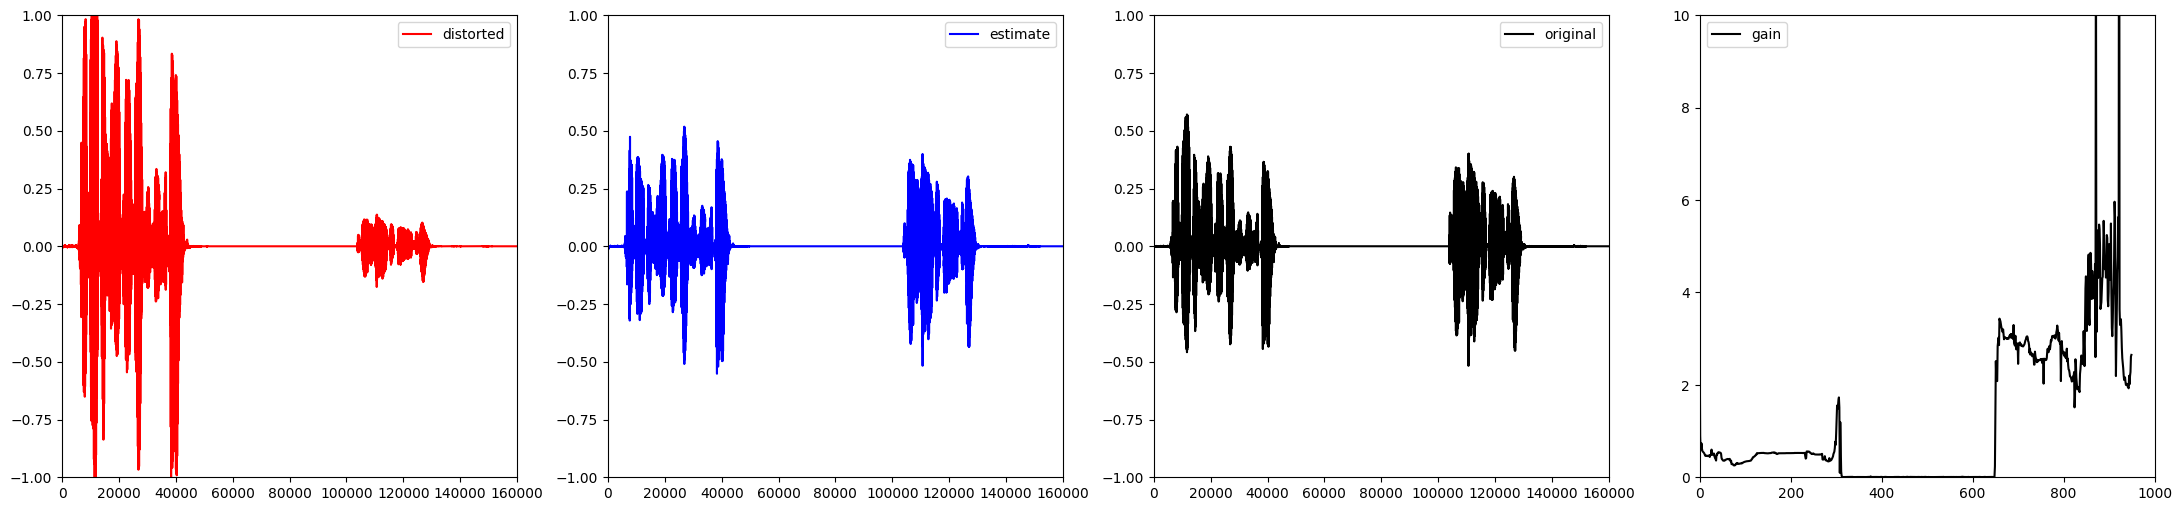

elapsed time: 270.5ms
loss: 0.05655071884393692


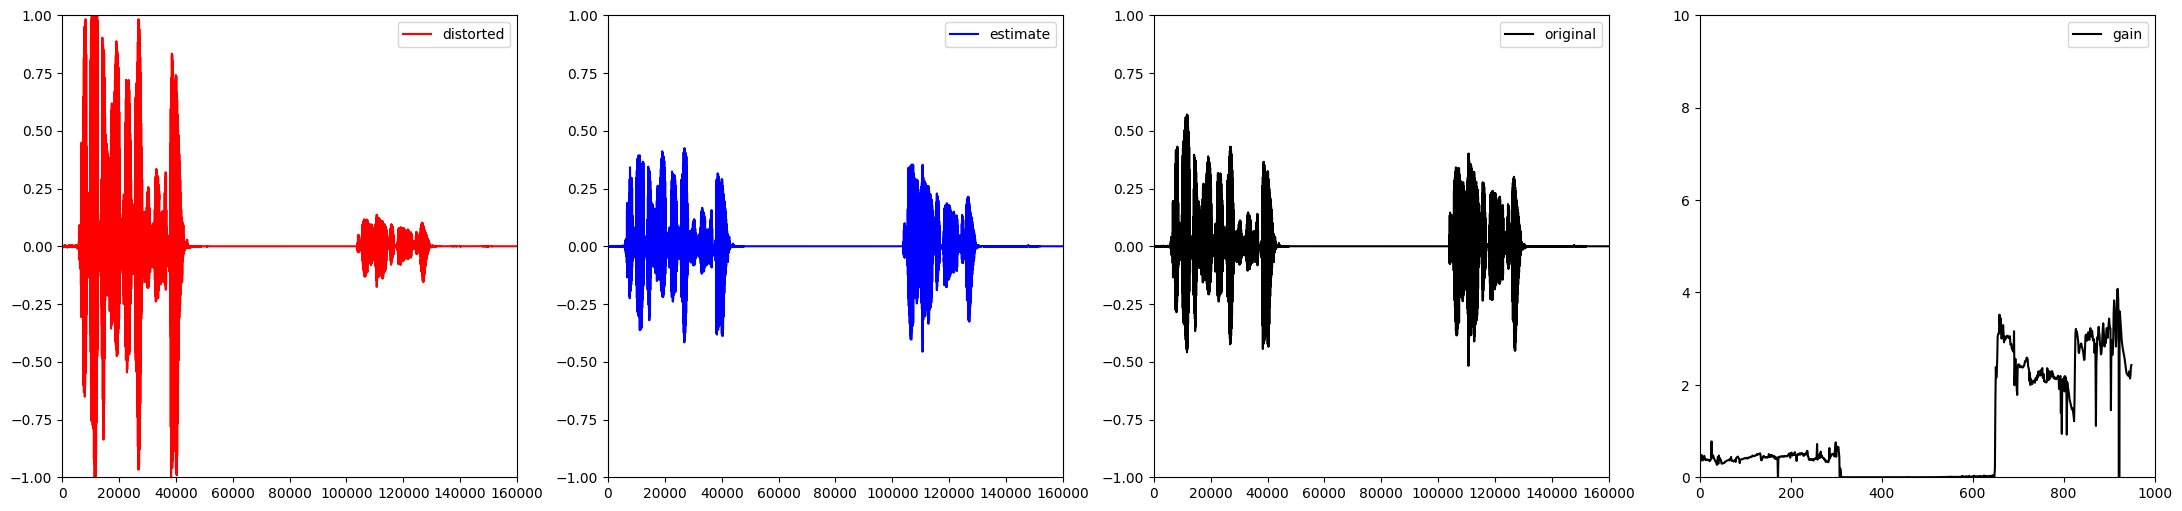

In [16]:
import time
import soundfile as sf

wav, gt = 0, 0

for i, data in enumerate(tt_dataloader):
    start = time.time()
    wav, gt = data['distorted'], data['original']
    wav = wav.cpu()
    gt = gt.cpu()
    
    start = time.time()
    est, _ = model(wav)
    print('elapsed time:{0: .1f}ms'.format((time.time() - start) * 1000))
    criterion = torch.nn.MSELoss()
    loss = criterion(torch.log(torch.abs(est) + 1e-5), torch.log(torch.abs(gt) + 1e-5))
    
    est = est[0].cpu().detach()

    gt = gt[0].float().cpu()
    
    wav = wav[0].cpu()
    print('loss: {}'.format(loss))

    #calc gain
    wav_chunk = torch.chunk(wav, 1000, dim=0)
    est_chunk = torch.chunk(est, 1000, dim=0)
    gain = []
    
    for j in range(1000):
        gain.append(torch.sum(est_chunk[j]) / torch.sum(wav_chunk[j]))


    
    plt.figure(figsize=[27, 6])
    plt.subplot(1, 4, 1)
    plt.axis([0, 160000, -1, 1])
    plt.plot(wav, color='red', label='distorted')
    plt.legend()
    plt.subplot(1, 4, 2)
    plt.axis([0, 160000, -1, 1])
    plt.plot(est, color='blue', label='estimate')
    plt.legend()
    plt.subplot(1, 4, 3)
    plt.axis([0, 160000, -1, 1])
    plt.plot(gt, color='black', label='original')
    plt.legend()
    plt.subplot(1, 4, 4)
    plt.axis([0, 1000, 0, 10])
    plt.plot(gain, color='black', label='gain')
    plt.legend()
    plt.show()

    sf.write('wave_original.wav', data=gt, samplerate=16000)
    sf.write('wave_estimate.wav', data=est, samplerate=16000)
    sf.write('wave_distorted.wav', data=wav, samplerate=16000)
    
    break

#############################################################################

wav = wav.unsqueeze(0)
gt = gt.unsqueeze(0)

#############################################################################

for i, data in enumerate(tt_dataloader):
    start = time.time()
    wav = wav.cpu()
    gt = gt.cpu()
    
    start = time.time()
    est, _ = model_40(wav)
    print('elapsed time:{0: .1f}ms'.format((time.time() - start) * 1000))
    criterion = torch.nn.MSELoss()
    loss = criterion(torch.log(torch.abs(est) + 1e-5), torch.log(torch.abs(gt) + 1e-5))
    
    est = est[0].cpu().detach()

    gt = gt[0].float().cpu()
    
    wav = wav[0].cpu()
    print('loss: {}'.format(loss))

    #calc gain
    wav_chunk = torch.chunk(wav, 1000, dim=0)
    est_chunk = torch.chunk(est, 1000, dim=0)
    gain = []
    
    for j in range(1000):
        gain.append(torch.sum(est_chunk[j]) / torch.sum(wav_chunk[j]))


    
    plt.figure(figsize=[27, 6])
    plt.subplot(1, 4, 1)
    plt.axis([0, 160000, -1, 1])
    plt.plot(wav, color='red', label='distorted')
    plt.legend()
    plt.subplot(1, 4, 2)
    plt.axis([0, 160000, -1, 1])
    plt.plot(est, color='blue', label='estimate')
    plt.legend()
    plt.subplot(1, 4, 3)
    plt.axis([0, 160000, -1, 1])
    plt.plot(gt, color='black', label='original')
    plt.legend()
    plt.subplot(1, 4, 4)
    plt.axis([0, 1000, 0, 10])
    plt.plot(gain, color='black', label='gain')
    plt.legend()
    plt.show()

    sf.write('wave_original.wav', data=gt, samplerate=16000)
    sf.write('wave_estimate.wav', data=est, samplerate=16000)
    sf.write('wave_distorted.wav', data=wav, samplerate=16000)
    
    break

max frame inference time: 0.63ms


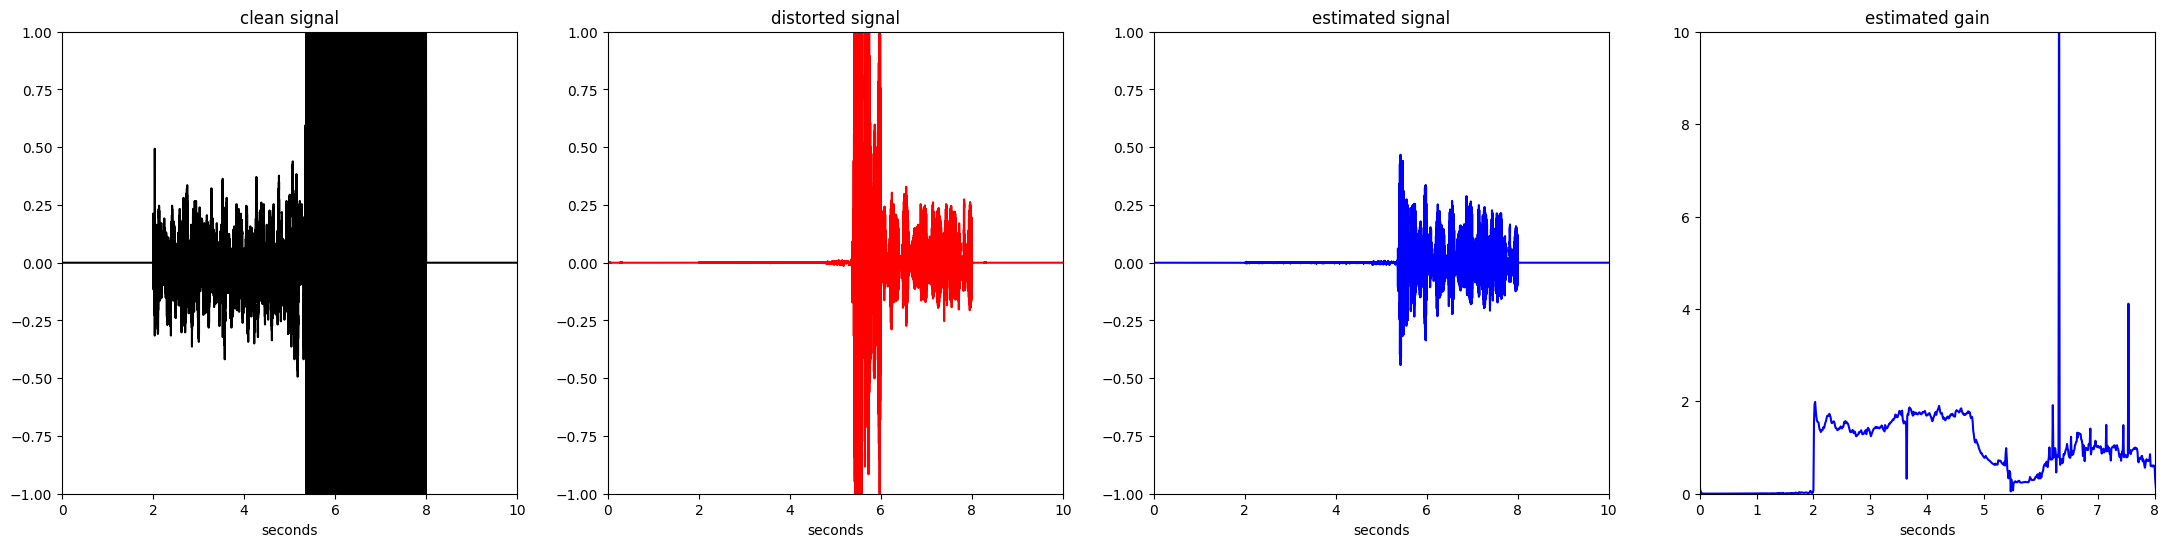

max frame inference time: 0.62ms


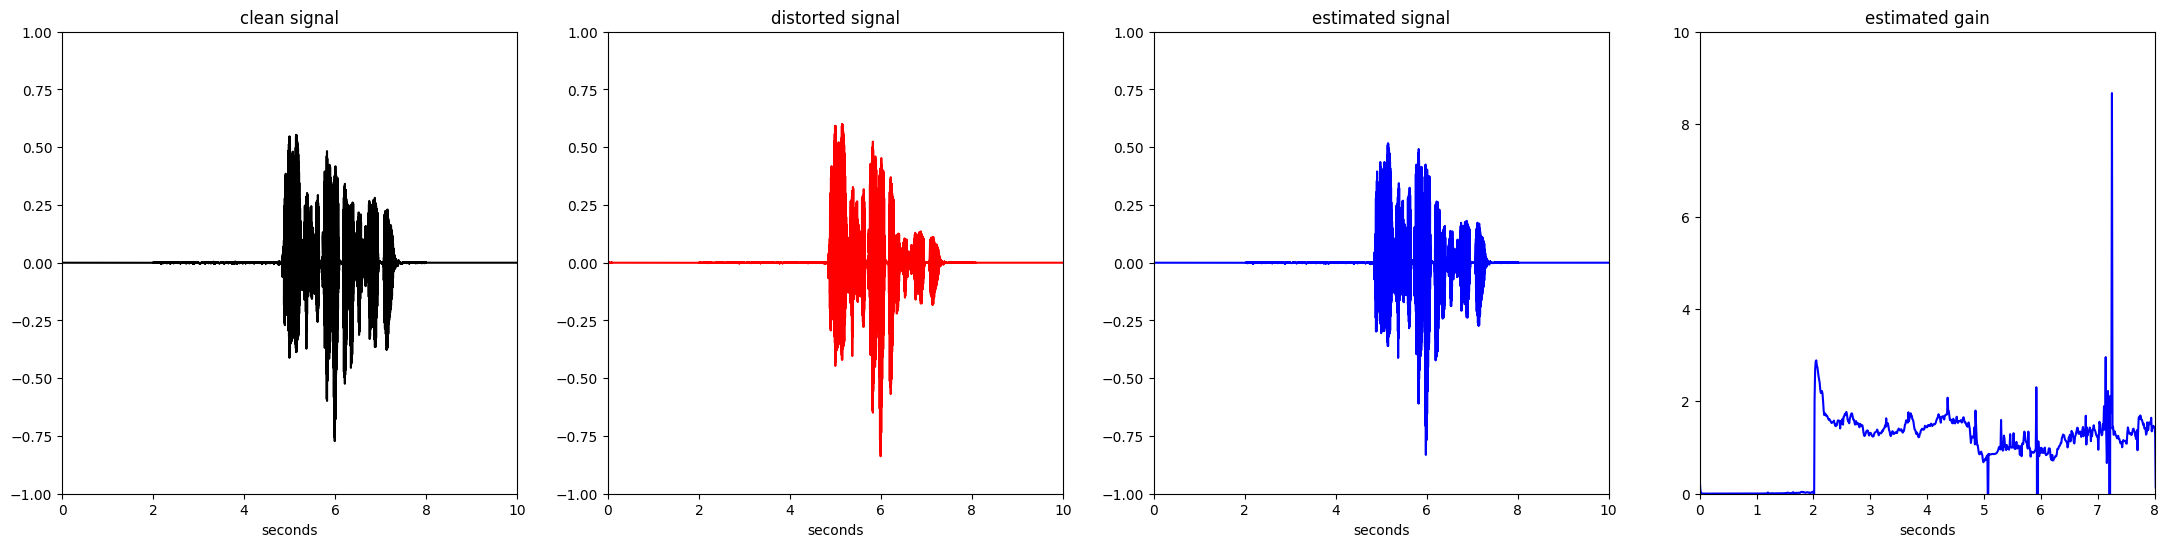

In [4]:
import time
import soundfile as sf
import numpy as np

frame_time_max = 0

for i in range(2):
    start = time.time()
    if i == 0:
        wav = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/distorted/distorted_17_44892_20973_5.647287885678192.wav')[0] 
        gt = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/original/original_17.wav')[0]
    elif i == 1:
        wav = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/distorted/distorted_4_45501_23117_2.243696616589303.wav')[0]
        gt = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/original/original_4.wav')[0]
    
    wav = torch.FloatTensor(wav)
    gt = torch.FloatTensor(gt)

    wav = wav.unsqueeze(0).cpu()
    gt = gt.unsqueeze(0).cpu()

    est, _ = model(wav)

    hidden = None

    for frame in range(100):
        start = time.time()
        wav_frame = wav[...,frame*80:(frame+2)*80]
        est_frame, hidden = model(wav_frame, hidden)
        end  = time.time()
        elapsed = end - start
        if frame_time_max < elapsed:
            frame_time_max = elapsed

        # if frame > 0:
        #     assert torch.allclose(est[...,(frame+1)*80:(frame+2)*80], est_frame)
    
    print('max frame inference time: {0:.2f}ms'.format(elapsed * 1000))
    
    est = est[0].cpu().detach()

    gt = gt[0].float().cpu()
    
    wav = wav[0].cpu()

    #calc gain
    wav_chunk = torch.chunk(wav, 1000, dim=0)
    est_chunk = torch.chunk(est, 1000, dim=0)
    gain = []
    
    for j in range(1000):
        gain.append(torch.sum(est_chunk[j]) / torch.sum(wav_chunk[j]))

    xaxis = np.arange(0, 10, 1/16000)
    xaxis2 = np.arange(0, 10, 1/100)


    plt.figure(figsize=[27, 6])
    plt.subplot(1, 4, 1)
    plt.axis([0, 10, -1, 1])
    plt.plot(xaxis, gt, color='black')
    plt.xlabel('seconds')
    plt.title('clean signal')
    plt.subplot(1, 4, 2)
    plt.axis([0, 10, -1, 1])
    plt.plot(xaxis, wav, color='red')
    plt.xlabel('seconds')
    plt.title('distorted signal')
    plt.subplot(1, 4, 3)
    plt.axis([0, 10, -1, 1])
    plt.plot(xaxis, est, color='blue')
    plt.xlabel('seconds')
    plt.title('estimated signal')
    plt.subplot(1, 4, 4)
    plt.axis([0, 8, 0, 10])
    plt.plot(xaxis2, gain, color='blue')
    plt.xlabel('seconds')
    plt.title('estimated gain')
    plt.show()

    # sf.write('wave_original.wav', data=gt, samplerate=16000)
    # sf.write('wave_estimate.wav', data=est, samplerate=16000)
    # sf.write('wave_distorted.wav', data=wav, samplerate=16000)

    if i == 0:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/estimate_17_yhjeon.wav', data=est, samplerate=16000)
    elif i == 1:
        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/estimate_4_yhjeon.wav', data=est, samplerate=16000)



    # win len, hop len 계산해주는 코드 작성하기


In [ ]:
import time
import soundfile as sf
import numpy as np

frame_time_max = 0

for i in range(2):
    start = time.time()
    if i == 0:
        wav = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/data/female.wav')[0] 
        gt = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/original/original_4.wav')[0]
    elif i == 1:
        wav = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/data/male.wav')[0]
        gt = sf.read('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/valid/original/original_773.wav')[0]
    
    wav = torch.FloatTensor(wav)
    gt = torch.FloatTensor(gt)

    wav = wav.unsqueeze(0).cpu()
    gt = gt.unsqueeze(0).cpu()

    est, _ = model(wav)

    hidden = None

    for frame in range(100):
        start = time.time()
        wav_frame = wav[...,frame*80:(frame+2)*80]
        est_frame, hidden = model(wav_frame, hidden)
        end  = time.time()
        elapsed = end - start
        if frame_time_max < elapsed:
            frame_time_max = elapsed

        # if frame > 0:
        #     assert torch.allclose(est[...,(frame+1)*80:(frame+2)*80], est_frame)
    
    print('max frame inference time: {0:.2f}ms'.format(elapsed * 1000))
    
    est = est[0].cpu().detach()

    gt = gt[0].float().cpu()
    
    wav = wav[0].cpu()

    #calc gain
    wav_chunk = torch.chunk(wav, 1000, dim=0)
    est_chunk = torch.chunk(est, 1000, dim=0)
    gain = []
    
    for j in range(800):
        gain.append(torch.sum(est_chunk[j]) / torch.sum(wav_chunk[j]))

    xaxis = np.arange(0, 10, 1/16000)
    xaxis2 = np.arange(0, 8, 1/100)


    
    plt.figure(figsize=[7, 6])
    # plt.subplot(1, 4, 1)
    # plt.axis([0, 10, -1, 1])
    # plt.plot(xaxis, gt, color='black')
    # plt.xlabel('seconds')
    # plt.title('clean signal')
    # plt.subplot(1, 4, 2)
    # plt.axis([0, 10, -1, 1])
    # plt.plot(xaxis, wav, color='red')
    # plt.xlabel('seconds')
    # plt.title('distorted signal')
    # plt.subplot(1, 4, 3)
    # plt.axis([0, 10, -1, 1])
    # plt.plot(xaxis, est, color='blue')
    # plt.xlabel('seconds')
    # plt.title('estimated signal')
    # plt.subplot(1, 4, 4)
    plt.axis([0, 8, 0, 10])
    plt.plot(xaxis2, gain, color='blue')
    plt.xlabel('seconds')
    plt.title('estimated gain')
    plt.show()

    # sf.write('wave_original.wav', data=gt, samplerate=16000)
    # sf.write('wave_estimate.wav', data=est, samplerate=16000)
    # sf.write('wave_distorted.wav', data=wav, samplerate=16000)

    # if i == 0:
    #     sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/female_en_p_s.wav', data=est, samplerate=16000)
    # elif i == 1:
    #     sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/male_en_p_s.wav', data=est, samplerate=16000)



    # win len, hop len 계산해주는 코드 작성하기


max frame inference time: 0.74ms


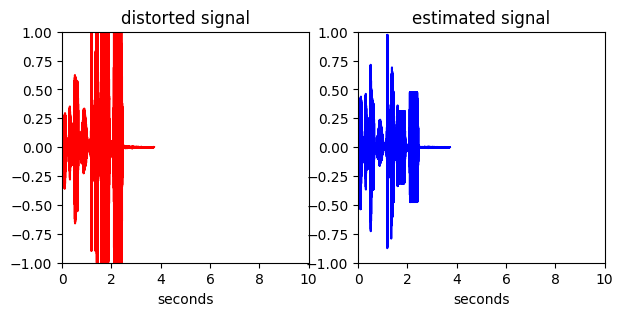

max frame inference time: 0.57ms


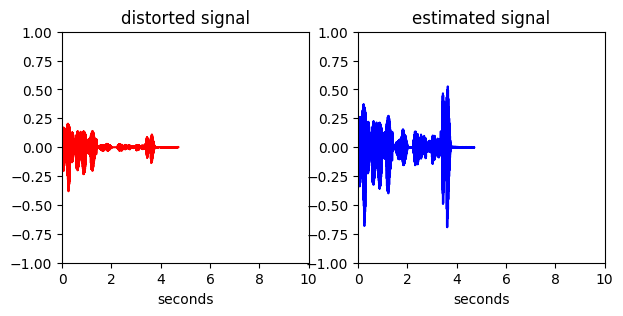

max frame inference time: 0.68ms


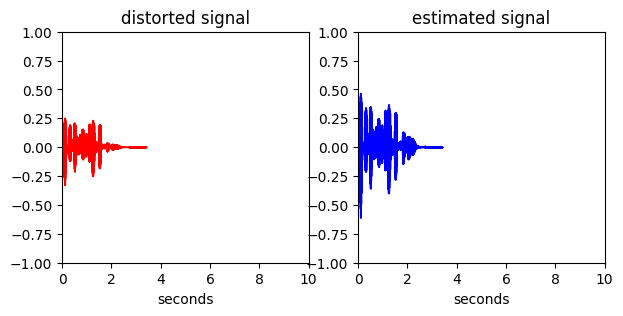

max frame inference time: 0.69ms


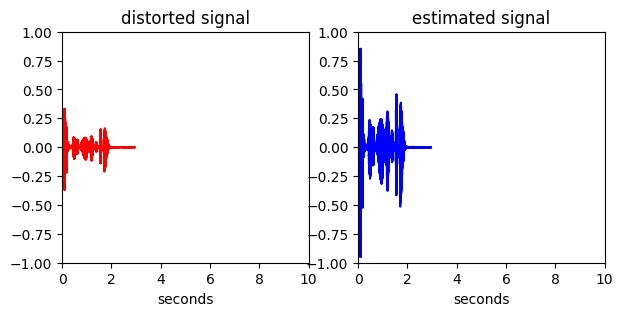

max frame inference time: 0.69ms


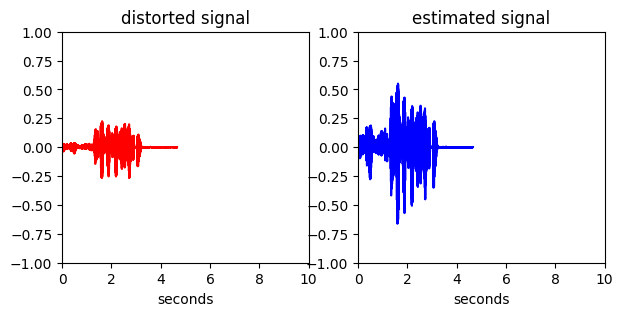

max frame inference time: 0.57ms


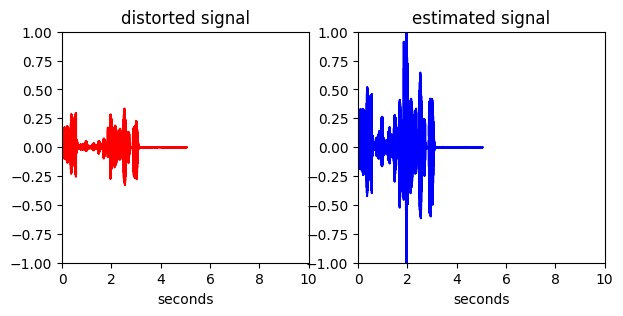

max frame inference time: 0.57ms


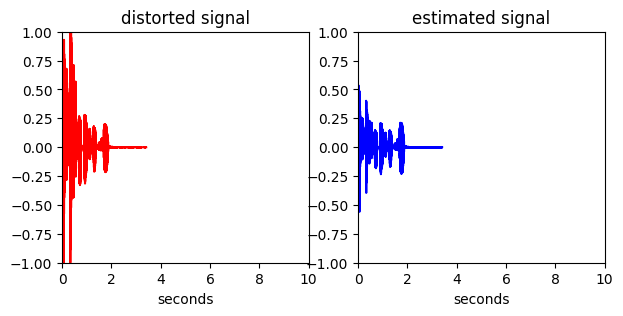

max frame inference time: 0.69ms


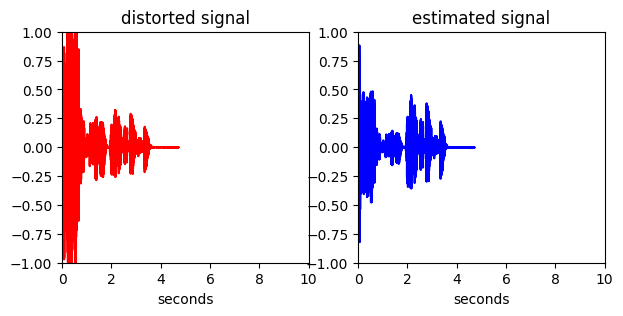

max frame inference time: 0.46ms


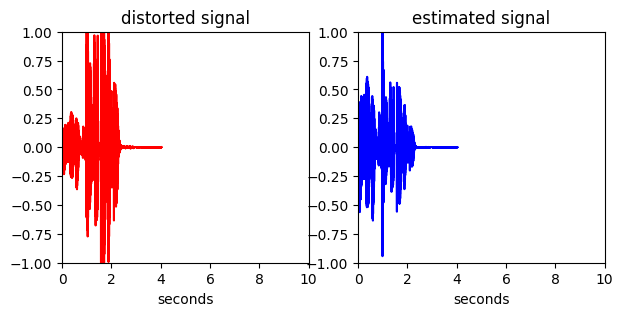

max frame inference time: 0.59ms


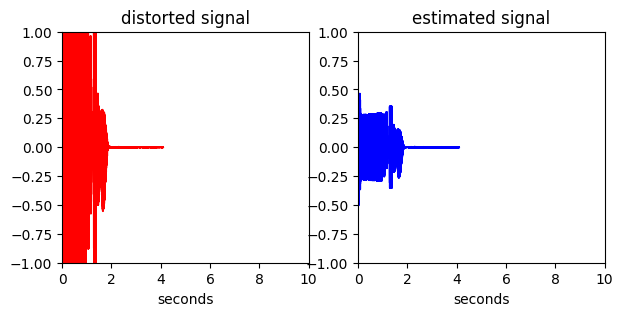

max frame inference time: 0.64ms


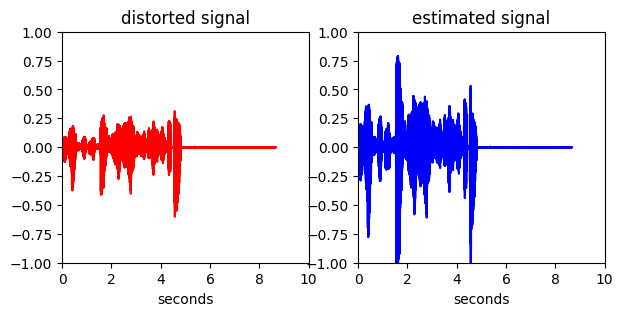

max frame inference time: 0.63ms


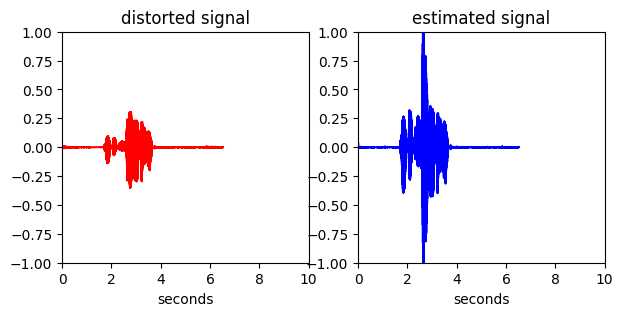

max frame inference time: 0.63ms


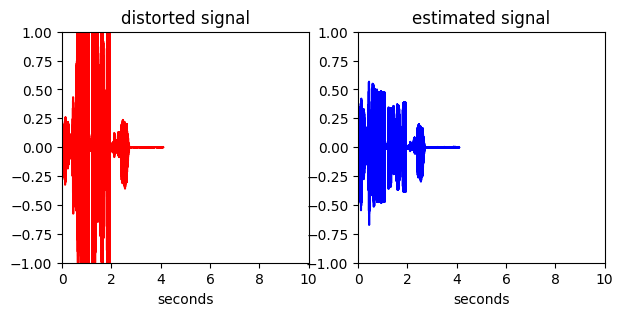

max frame inference time: 0.68ms


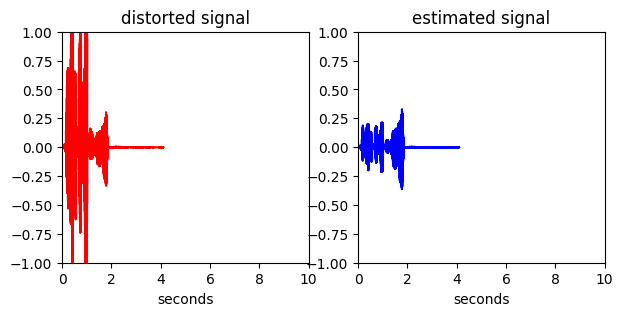

max frame inference time: 0.46ms


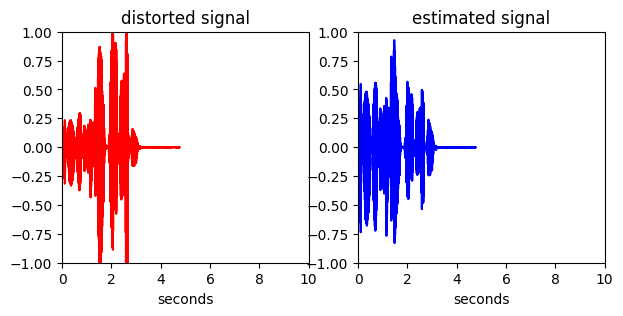

max frame inference time: 0.59ms


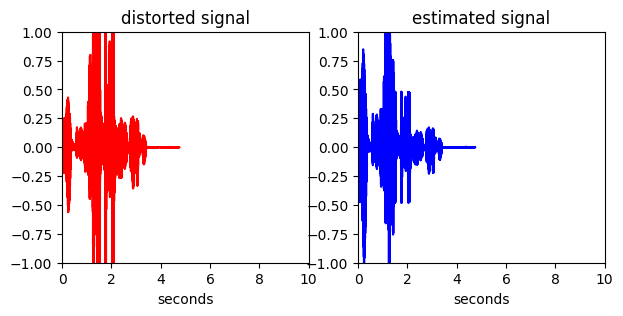

max frame inference time: 0.64ms


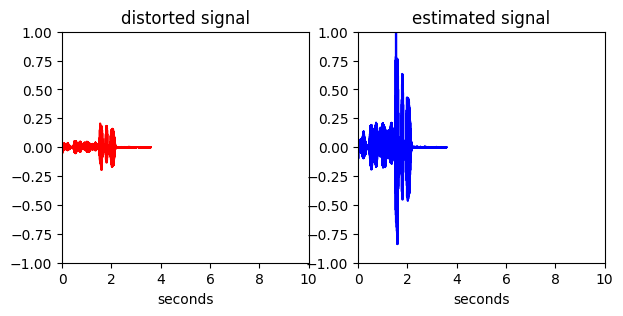

max frame inference time: 0.64ms


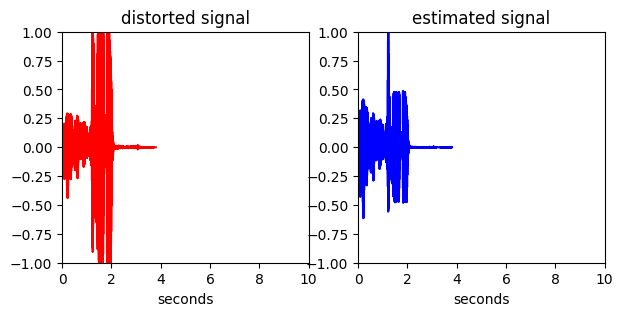

max frame inference time: 0.61ms


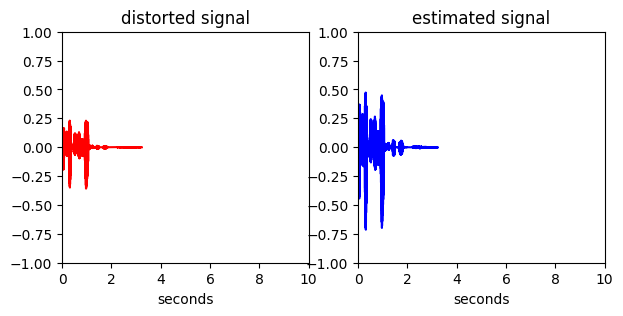

max frame inference time: 0.49ms


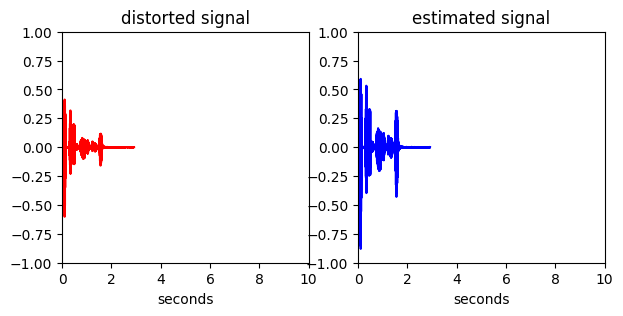

max frame inference time: 0.57ms


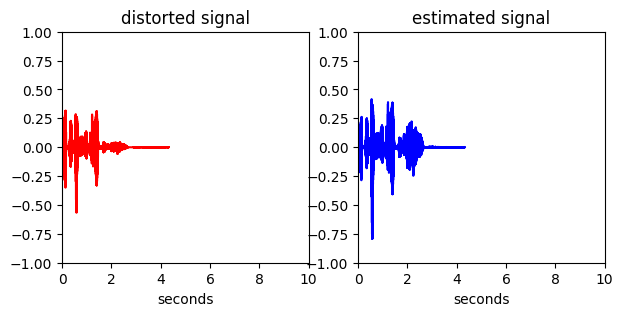

max frame inference time: 0.57ms


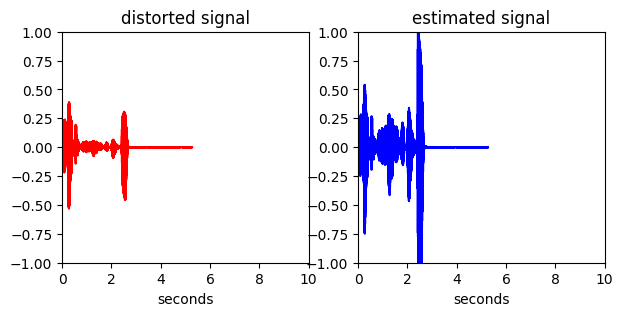

max frame inference time: 0.57ms


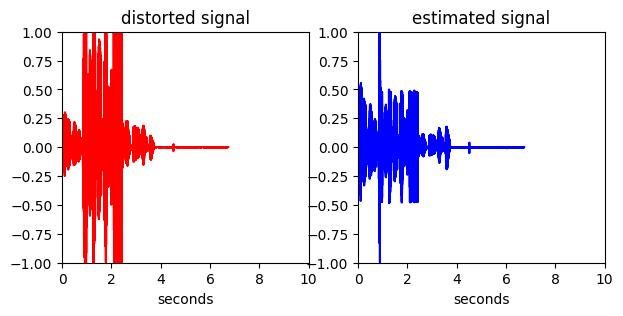

max frame inference time: 0.68ms


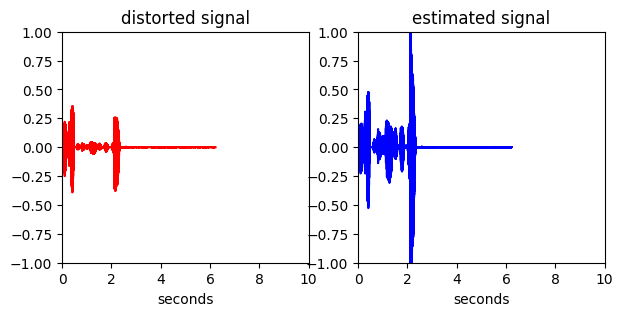

max frame inference time: 0.46ms


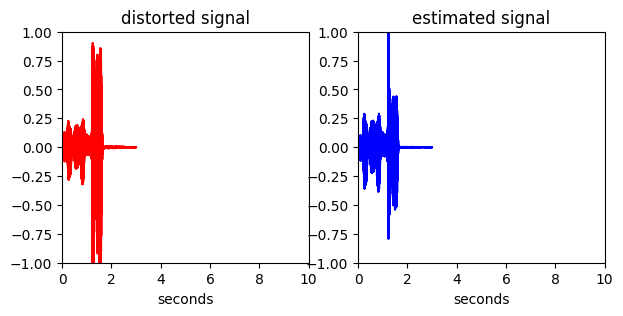

max frame inference time: 0.55ms


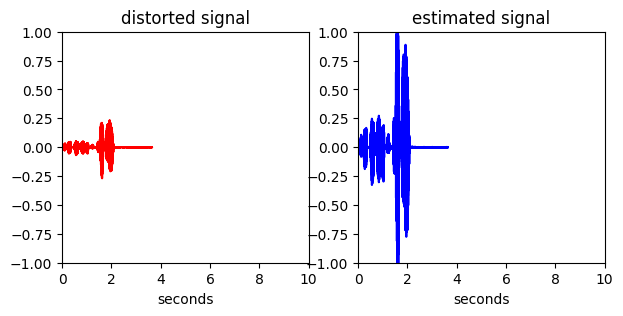

max frame inference time: 0.75ms


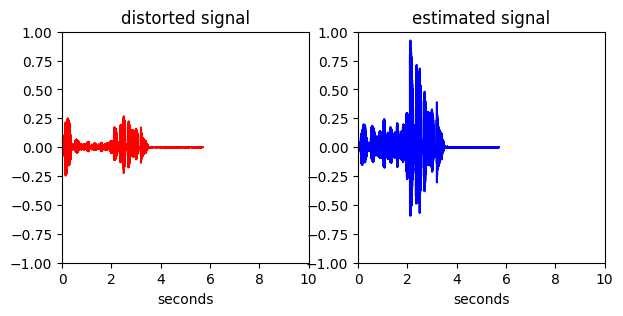

max frame inference time: 0.63ms


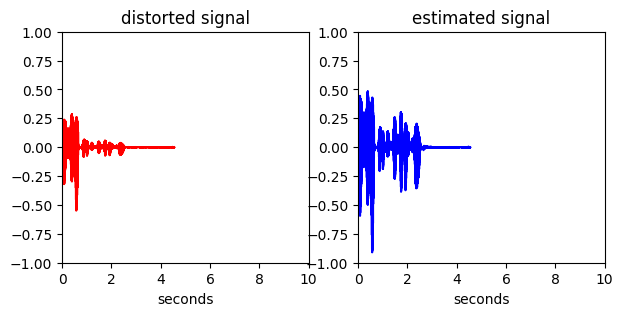

max frame inference time: 0.67ms


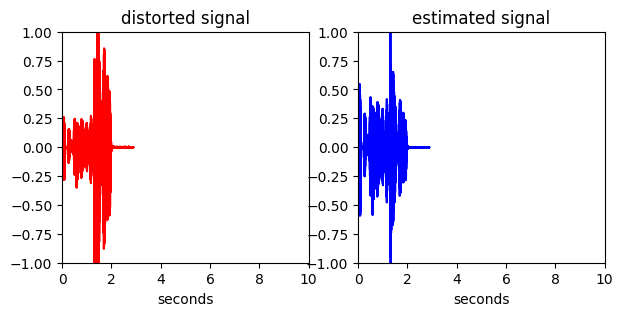

max frame inference time: 0.74ms


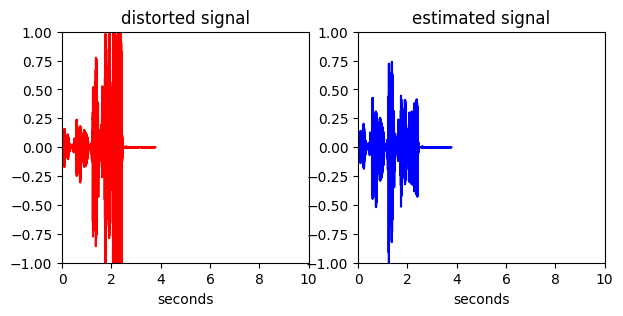

: 

In [5]:
import time
import soundfile as sf
import numpy as np
import os
import torch

frame_time_max = 0

for root, directories, files in os.walk('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/test/distorted'):
    for file in files:
        wav = sf.read(os.path.join(root, file))[0]
        filenum = file.split('_')[1]
    
        wav = torch.FloatTensor(wav)

        wav = wav.unsqueeze(0).cpu()

        est, _ = model_5(wav)

        hidden = None

        for frame in range(100):
            start = time.time()
            wav_frame = wav[...,frame*80:(frame+2)*80]
            est_frame, hidden = model(wav_frame, hidden)
            end  = time.time()
            elapsed = end - start
            if frame_time_max < elapsed:
                frame_time_max = elapsed

            # if frame > 0:
            #     assert torch.allclose(est[...,(frame+1)*80:(frame+2)*80], est_frame)
        
        print('max frame inference time: {0:.2f}ms'.format(elapsed * 1000))
        
        est = est[0].cpu().detach()
        
        wav = wav[0].cpu()


        xaxis = np.arange(0, wav.shape[0]/16000, 1/16000)

        
        plt.figure(figsize=[7, 3])
        plt.subplot(1, 2, 1)
        plt.axis([0, 10, -1, 1])
        plt.plot(xaxis, wav, color='red')
        plt.xlabel('seconds')
        plt.title('distorted signal')
        plt.subplot(1, 2, 2)
        plt.axis([0, 10, -1, 1])
        plt.plot(xaxis, est, color='blue')
        plt.xlabel('seconds')
        plt.title('estimated signal')

        plt.show()

        sf.write('/home/yhjeon/projects/IITP_SE/NS_AGC/data/SITEC_AGC/test/estimate_5/estimate_{0}.wav'.format(filenum), data=est, samplerate=16000)



In [5]:
import torch, torchaudio
print(torch.__version__, torchaudio.__version__)

1.13.1+cu117 0.13.1+cu117
